# (Bonus notebook) Training with a minimal version of the dataset

This is a demo on how to run the training script with downloaded data inside Colab. Note that this is just a fast demo (the "mini" dataset here doesn't represent the full data) and that some small alterations in code were made to allow running in Colab - for full runs, please install the code on your own machine.

## 1 Prepare code, data and libraries

In [ ]:
!pip install --quiet rasterio
!pip install --quiet --upgrade gdown

In [ ]:
# Clone the repository:
!git clone https://github.com/spaceml-org/STARCOP.git

In [ ]:
# Data:
# STARCOP_mini.zip with 261 MB
!gdown https://drive.google.com/uc?id=1Qw96Drmk2jzBYSED0YPEUyuc2DnBechl -O STARCOP_mini.zip
!unzip -q STARCOP_mini.zip
# clean-up
!rm *.zip

# The train script will expect the test dataset in the "test.csv" - so here in this small demo we just place the small subset there instead:
!cp STARCOP_mini/test_mini10.csv STARCOP_mini/test.csv

In [7]:
!ls

hyperstarcop_magic_rgb	multistarcop_varon  sample_data  STARCOP  STARCOP_mini


In [8]:
%cd /content/STARCOP

/content/STARCOP


In [9]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing meta

In [10]:
# Additional libraries and exact versions:
!pip install git+https://github.com/spaceml-org/georeader.git
!pip install torchmetrics==0.10.0

# we also need to downgrade kornia to match the used version
!pip install kornia==0.6.7

  Cloning https://github.com/spaceml-org/georeader.git to /tmp/pip-req-build-tfrfokdj
  Running command git clone --filter=blob:none --quiet https://github.com/spaceml-org/georeader.git /tmp/pip-req-build-tfrfokdj
  Resolved https://github.com/spaceml-org/georeader.git to commit 06b92dba0f91f575c725d894fd53ddafe7e851dd
  Preparing metadata (setup.py) ... done
  Created wheel for georeader-spaceml: filename=georeader_spaceml-1.0.4-py3-none-any.whl size=131048 sha256=cdf9bf1d5d99b34eb8b4219aae64a0eae1ca0b009ead44ed52a92645e067e0b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-s_53101u/wheels/d2/8e/86/ec6888325df45badf27fbc6acbb49d9d0432d04ddf3b8020b4
Successfully built georeader-spaceml
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.2/529.2 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: torchmetrics
    Found existing installation: torchmetrics 1.2.0
    Uninstalling torchmetrics-1.2.0:
      Successfully uninstalled torchmetrics-1.2.0


In [ ]:
assert False
# please restart the runtime with the button above ^

## 2 Run the train script

In [3]:
%cd /content/STARCOP

/content/STARCOP


Here we show a sample run of the scripts.train code - with some example settings.

In [ ]:
# We will use some of the example commands also shown in this script:
#!cat bash/bash_train_example.sh

# You can also check the output of the help:
#!python -m scripts.train --help

### 2.1 Adjust the code for Colab

**When using Colab** we change few details in the code to run with the newest version of the libraries. We also turn off logging with Wandb and copying data into a gs bucket.

In [2]:
%%writefile scripts/train_colab.py
import matplotlib
matplotlib.use('agg')

import os
import hydra
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer
from starcop.dataset_setup import get_dataset
from starcop.model_setup import get_model
from starcop.data.data_logger import ImageLogger
from hydra.utils import get_original_cwd
import logging
import fsspec
from starcop.validation import  run_validation
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt

@hydra.main(version_base=None, config_path="configs", config_name="config")
def train(settings : DictConfig) -> None:
    experiment_path = os.getcwd()
    folder_relative_name = experiment_path.replace(get_original_cwd(), "") #remove beginning of path

    log = logging.getLogger(__name__)

    checkpoint_path = os.path.join(experiment_path, "checkpoint").replace("\\", "/")
    if not experiment_path.startswith("gs://"):
        os.makedirs(experiment_path, exist_ok=True)

    if not checkpoint_path.startswith("gs://"):
        os.makedirs(checkpoint_path, exist_ok=True)

    # Set up remote path
    if folder_relative_name.startswith("/"):
        folder_relative_name = folder_relative_name[1:]
    if not folder_relative_name.endswith("/"):
        folder_relative_name += "/"
    remote_path = os.path.join("gs://starcop/", folder_relative_name)

    OmegaConf.set_struct(settings, False)
    settings["experiment_path"] = experiment_path
    settings["experiment_path"] = remote_path

    log.info(f"trained models will be save at {experiment_path}")
    log.info(f"At the end of training, models will be copied to {remote_path}")

    plt.ioff()

    # LOGGING SETUP
    log.info("SETTING UP LOGGERS")
    # Change vs the main code - commented the Wandb logging:
    # wandb_logger = WandbLogger(
    #     name=settings.experiment_name,
    #     project=settings.wandb.wandb_project,
    #     entity=settings.wandb.wandb_entity,
    # )
    # # wandb.config.update(settings)
    # wandb_logger.experiment.config.update(settings)

    # settings["wandb_logger_version"] = wandb_logger.version
    OmegaConf.set_struct(settings, True)

    log.info(f"Settings dump:{OmegaConf.to_yaml(settings)}")
    log.info(f"Using matplotlib backend: {matplotlib.get_backend()}")

    # ======================================================
    # EXPERIMENT SETUP
    # ======================================================
    # Seed
    seed_everything((None if settings.seed == "None" else settings.seed))

    # DATASET SETUP
    log.info("SETTING UP DATASET")
    data_module = get_dataset(settings)
    data_module.prepare_data()

    # MODEL SETUP
    log.info("SETTING UP MODEL")
    settings.model.test = False
    settings.model.train = True
    model = get_model(settings, settings.experiment_name)

    # CHECKPOINTING SETUP
    log.info("SETTING UP CHECKPOINTING")

    metric_monitor ="val_loss"
    checkpoint_callback = ModelCheckpoint(
        dirpath=checkpoint_path,
        save_top_k=True,
        verbose=True,
        monitor=metric_monitor,
        mode="min"
    )

    early_stop_callback = EarlyStopping(
        monitor=metric_monitor,
        patience=settings.model.early_stopping_patience,
        strict=False,
        verbose=False,
        mode="min"
    )

    # Images for logs from the first batch
    batch_train = next(iter(data_module.train_plot_dataloader(batch_size=settings.plot_samples)))
    batch_test = next(iter(data_module.test_plot_dataloader(batch_size=settings.plot_samples)))

    # il = ImageLogger(batch_train=batch_train,
    #                  batch_test=batch_test, products_plot=settings.products_plot,
    #                  input_products=settings.dataset.input_products)
    #callbacks = [checkpoint_callback, il]
    callbacks = [checkpoint_callback]

    # TRAINING SETUP
    log.info("START TRAINING")

    # See: https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html
    trainer = Trainer(
        fast_dev_run=False,
        logger=None, ### < change
        callbacks=callbacks,
        default_root_dir=experiment_path,
        accumulate_grad_batches=1,
        gradient_clip_val=0.0,
        benchmark=False,
        accelerator=settings.training.accelerator,
        devices=settings.training.devices,
        max_epochs=settings.training.max_epochs,
        # check_val_every_n_epoch=settings.training.val_every,
        val_check_interval=settings.training.val_check_interval,
        # Pass a float in the range [0.0, 1.0] to check after a fraction of the training epoch. Pass an int to check after a fixed number of training batches. An int value can only be higher than the number of training batches when
        log_every_n_steps=settings.training.train_log_every_n_steps,

        #no longer used in newer versions of the library:
        #auto_select_gpus=True,
        #auto_lr_find=False,
        #resume_from_checkpoint=checkpoint_path if settings.resume_from_checkpoint else None,
    )

    trainer.fit(model, data_module)

    # Save model
    trainer.save_checkpoint(os.path.join(experiment_path, "final_checkpoint_model.ckpt"))

    print("Training finished!")

if __name__ == "__main__":
    train()


Writing scripts/train_colab.py


In [15]:
%%writefile /content/STARCOP/starcop/models/model_module.py
import torch
import torch.nn
import wandb
import numpy as np
import pytorch_lightning as pl
from typing import List, Optional, Dict, Tuple
from .utils import losses, metrics
from starcop.utils import get_filesystem
from .architectures.unet import UNet, UNet_dropout
from .architectures.baselines import SingleConv, SimpleCNN
import torchmetrics
from starcop.data.normalizer_module import DataNormalizer
from starcop import metrics


def to_tensor(v):
    if isinstance(v,list):
        v=torch.tensor(v)
    elif isinstance(v,np.ndarray):
        v=torch.from_numpy(v)
    return v


class ModelModule(pl.LightningModule):

    def __init__(self, settings):
        super().__init__()
        self.save_hyperparameters()
        self.settings_model = settings.model
        self.settings_wandb = settings.wandb
        self.normalizer = DataNormalizer(settings)

        self.num_classes = self.settings_model.num_classes
        self.num_channels = len(settings.dataset.input_products)

        architecture = self.settings_model.model_type
        self.network = configure_architecture(architecture, self.num_channels, self.num_classes, self.settings_model)

        # learning rate params
        self.lr = self.settings_model.lr
        self.lr_decay = self.settings_model.lr_decay
        self.lr_patience = self.settings_model.lr_patience

        self.loss_name = self.settings_model.loss

        use_weight_loss = "use_weight_loss" not in settings.dataset or settings.dataset.use_weight_loss
        if self.settings_model.loss == 'l1':
            self.loss_function = losses.l1
            self.loss_name = "l1_loss"
        elif self.settings_model.loss == 'mse':
            self.loss_function = losses.mse
            self.loss_name = "mse_loss"
        elif self.settings_model.loss == "BCEWithLogitsLoss":
            self.reduction = "none" if use_weight_loss else "mean"
            self.pos_weight = torch.nn.Parameter(torch.tensor(float(self.settings_model.pos_weight)),
                                                 requires_grad=False)
            self.loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight,
                                                            reduction=self.reduction)

        # Configure metrics based on settings_model.model_mode: "segmentation_output" # regression_output
        if self.settings_model.model_mode == "segmentation_output":
            self.confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=2)
            self.classification_confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=2)


        elif self.settings_model.model_mode == "regression_output":
            raise NotImplementedError("Not implemented yet")

    def training_step(self, batch: Dict, batch_idx) -> float:
        x, y = batch["input"], batch["output"]

        if self.reduction == "none":
            weight_loss = batch["weight_loss"]

        predictions = self.forward(x) # (B, 1, H, W)
        loss = self.loss_function(predictions, self.normalizer.normalize_y(y)) # (B, 1, W, H)

        if self.reduction == "none":
            loss = torch.mean(loss * weight_loss)

        if (batch_idx % 100) == 0:
            self.log(f"train_{self.loss_name}", loss)

        # if (batch_idx == 0) and (self.logger is not None) and isinstance(self.logger, WandbLogger):
        #     with torch.no_grad():
        #         self.log_images(x, y, predictions, prefix="train_")

        return loss

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (B, num_channels, H, W) input tensor

        Returns:
            (B, 1, H, W) prediction of the network
        """
        return self.network(self.normalizer.normalize_x(x))

    def pred_classification(self, pred_binary:torch.Tensor) -> torch.Tensor:
        return pred_classification(pred_binary)

    def log(self, *args, **kwargs):
        try:
            super().log(*args,**kwargs)
        except Exception as e:
            print(f"Bug logging {e}")


    def val_step(self, batch, batch_idx:int, prefix:str="val"):
        x, y = batch["input"], batch["output"]

        predictions = self.forward(x)
        y = self.normalizer.normalize_y(y)
        loss = self.loss_function(predictions, y)

        if self.reduction == "none":
            weight_loss = batch["weight_loss"]
            loss = torch.mean(loss * weight_loss)

        self.log(f"{prefix}_loss", loss, on_epoch=True)

        if self.settings_model.model_mode == "segmentation_output":
            pred_binary = (predictions >= 0).long() # (B, 1, H, C)

            y_long = y.long() # (B, 1, H, C)

            self.confusion_matrix.update(pred_binary, y_long)

            y_classification = batch["has_plume"]
            y_classification = y_classification[:, None]

            pred_classification = self.pred_classification(pred_binary)

            self.classification_confusion_matrix.update(pred_classification, y_classification)

        # Visualizations
        # if (batch_idx == 0) and (self.logger is not None) and isinstance(self.logger, WandbLogger):
        #     self.log_images(x, y, predictions,prefix=prefix)

    def validation_step(self, batch, batch_idx: int):
        return self.val_step(batch, batch_idx, prefix="val")

    def test_step(self, batch, batch_idx: int) :
        return self.val_step(batch, batch_idx, prefix="test")

    def val_epoch_end(self, outputs, prefix):
        outs = {}
        cm = self.confusion_matrix.compute()

        for fun in metrics.METRICS_CONFUSION_MATRIX:
            self.log(f'{prefix}_{fun.__name__}', fun(cm))

        self.confusion_matrix.reset()

        if self.settings_model.model_mode == "segmentation_output":
            cm = self.classification_confusion_matrix.compute()

            for fun in metrics.METRICS_CONFUSION_MATRIX:
                self.log(f'{prefix}_classification_{fun.__name__}', fun(cm))

            self.classification_confusion_matrix.reset()

        return outs

    # Colab version > 2.0 would normally need edits - see https://github.com/Lightning-AI/lightning/discussions/17182
    # def validation_epoch_end(self, outputs) -> None:
    #     self.val_epoch_end(outputs, prefix="val")

    # def test_epoch_end(self, outputs) -> None:
    #     self.val_epoch_end(outputs, prefix="test")

    def configure_optimizers(self):
        if self.settings_model.optimizer == "adam":
            optimizer = torch.optim.Adam(self.network.parameters(), self.lr)
        else:
            raise Exception(f'No optimizer implemented for : {self.settings_model.optimizer}')

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                               mode="min",
                                                               factor=self.lr_decay, verbose=True,
                                                               patience=self.lr_patience)

        return {"optimizer": optimizer,
                "lr_scheduler": scheduler,
                "monitor": "val_loss"}

    def debug(self):
        print("Model debug:")
        print(self)

    def batch_with_preds(self, batch):
        logits = self(batch["input"])
        pred = torch.sigmoid(logits)

        batch = batch.copy()
        batch["input_norm"] = self.normalizer.normalize_x(batch["input"])
        batch["output_norm"] = self.normalizer.normalize_y(batch["output"])

        batch["prediction"] = pred
        batch["logits"] = logits
        if self.reduction == "none":
            batch["loss_per_pixel"] = self.loss_function(logits, batch["output_norm"])
            batch["loss_per_pixel_weighted"] = batch["weight_loss"] * batch["loss_per_pixel"]
        batch["pred_binary"] = (pred > .5).long()
        batch["differences"] = differences(batch["pred_binary"], batch["output_norm"].long())
        batch["pred_classification"] = self.pred_classification(batch["pred_binary"])

        return batch

def pred_classification(pred_binary:torch.Tensor) -> torch.Tensor:
    n_pixels = (10 * np.prod(tuple(pred_binary.shape[-2:]))) / (64 ** 2)
    return (torch.sum(pred_binary, dim=(-1, -2)) > n_pixels).long()  # (B, 1)


METRIC_MODE = {
    # In min mode, lr will be reduced when the quantity monitored has stopped decreasing
    "val_l1_loss": "min",
    "train_l1_loss": "min",
    "val_mse_loss": "min",
    "train_mse_loss": "min",
}


def configure_architecture(architecture, num_channels, num_classes, extra_settings_model):

    # if architecture == 'unet':
    #     model = UNet(num_channels, num_classes)
    #
    # elif architecture == 'cnn':
    #     model = SimpleCNN(num_channels, num_classes)
    #
    # elif architecture == 'single':
    #     model = SingleConv(num_channels, num_classes)
    #
    # elif architecture == 'unet_dropout':
    #     model = UNet_dropout(num_channels, num_classes)

    if architecture == 'unet_semseg':

        import segmentation_models_pytorch as smp
        BACKBONE = extra_settings_model.semseg_backbone
        PRETRAINED = 'imagenet' if num_channels == 3 else None

        model = smp.Unet(
            encoder_name=BACKBONE,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights=PRETRAINED,     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=num_channels,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=num_classes,                      # model output channels (number of classes in your dataset)
            activation=None,      # activation function, default is None
            # encoder_depth=4 # Depth parameter specify a number of downsampling operations in encoder, so you can make your model lighter if specify smaller depth
        )

    else:
        raise Exception(f'No model implemented for model_type: {architecture}')

    return model

def load_weights(path_weights:str, map_location="cpu"):
    fs = get_filesystem(path_weights)
    if fs.exists(path_weights):
        with fs.open(path_weights, "rb") as fh:
            weights = torch.load(fh, map_location=map_location)

        return weights

    raise ValueError(f"Pretrained weights file: {path_weights} does not exists")

def differences(y_pred_binary: torch.Tensor, y_gt:torch.Tensor) -> torch.Tensor:
    return 2 * y_pred_binary.long() + (y_gt == 1).long()

Overwriting /content/STARCOP/starcop/models/model_module.py


### 2.2 Run the training script

We will be using this training script:


```
python -m scripts.train \
  dataset.input_products=["mag1c","TOA_AVIRIS_640nm","TOA_AVIRIS_550nm","TOA_AVIRIS_460nm"] \
  # ^ selects the input products, in this case it's 4 products, the mag1c + RGB
  model.model_type='unet_semseg' model.pos_weight=1 \
  experiment_name="HyperSTARCOP_magic_rgb_DEMO" \
  dataloader.num_workers=4 dataset.use_weight_loss=True \
  training.val_check_interval=0.5 \
  training.max_epochs=5 \
  # ^ how many epochs?
  products_plot=["rgb_aviris","mag1c","label","pred","differences"] \
  # ^ which visualisation scripts should be called - matters mostly when logging to wandb, which is turned off here
  dataset.weight_sampling=True \
  dataset.train_csv="train_mini10.csv" dataset.root_folder=$root_folder
  # ^ important, selects which csv files will be used to load data and the root folder
  
```






In [4]:
import omegaconf
import pylab as plt
import torch
import omegaconf
import fsspec
import os
import json
import pandas as pd
import numpy as np
from starcop.torch_utils import to_device
import starcop.plot as starcoplot
from mpl_toolkits.axes_grid1 import make_axes_locatable

from starcop.data.datamodule import Permian2019DataModule
from starcop.models.model_module import ModelModule
from starcop.validation import run_validation

device = torch.device("cuda:0")
fs = fsspec.filesystem("gs")
config_general = omegaconf.OmegaConf.load("scripts/configs/config.yaml")
root_folder = "/content/STARCOP_mini"

In [5]:
!python -m scripts.train_colab dataset.input_products=["mag1c","TOA_AVIRIS_640nm","TOA_AVIRIS_550nm","TOA_AVIRIS_460nm"] model.model_type='unet_semseg' model.pos_weight=1 experiment_name="HyperSTARCOP_magic_rgb_DEMO" dataloader.num_workers=4 dataset.use_weight_loss=True training.val_check_interval=0.5 training.max_epochs=5 products_plot=["rgb_aviris","mag1c","label","pred","differences"] dataset.weight_sampling=True dataset.train_csv="train_mini10.csv" dataset.root_folder=$root_folder

[2023-11-16 17:29:40,762][__main__][INFO] - trained models will be save at /content/STARCOP/experiments/HyperSTARCOP_magic_rgb_DEMO/2023-11-16_17-29
[2023-11-16 17:29:40,763][__main__][INFO] - At the end of training, models will be copied to gs://starcop/experiments/HyperSTARCOP_magic_rgb_DEMO/2023-11-16_17-29/
[2023-11-16 17:29:40,763][__main__][INFO] - SETTING UP LOGGERS
[2023-11-16 17:29:40,769][__main__][INFO] - Settings dump:experiment_name: HyperSTARCOP_magic_rgb_DEMO
seed: None
resume_from_checkpoint: false
wandb:
  wandb_project: your_wandb_project
  wandb_entity: your_wandb_entity
  images_logging: wandb
dataloader:
  batch_size: 32
  num_workers: 4
products_plot:
- rgb_aviris
- mag1c
- label
- pred
- differences
plot_samples: 8
dataset:
  input_products:
  - mag1c
  - TOA_AVIRIS_640nm
  - TOA_AVIRIS_550nm
  - TOA_AVIRIS_460nm
  output_products:
  - labelbinary
  use_weight_loss: true
  weight_loss: weight_mag1c
  training_size:
  - 128
  - 128
  training_size_overlap:
  - 64


In [8]:
# Our training gets saved into:
!ls /content/STARCOP/experiments/HyperSTARCOP_magic_rgb_DEMO/
# (note the last folder name comes from the data - change it to your own)
saved_model_path = "/content/STARCOP/experiments/HyperSTARCOP_magic_rgb_DEMO/2023-11-16_17-29"

!ls $saved_model_path -lauh

2023-11-16_17-20  2023-11-16_17-24  2023-11-16_17-28
2023-11-16_17-22  2023-11-16_17-25  2023-11-16_17-29
total 77M
drwxr-xr-x 5 root root 4.0K Nov 16 17:32 .
drwxr-xr-x 8 root root 4.0K Nov 16 17:32 ..
drwxr-xr-x 2 root root 4.0K Nov 16 17:31 checkpoint
-rw-r--r-- 1 root root  77M Nov 16 17:31 final_checkpoint_model.ckpt
drwxr-xr-x 2 root root 4.0K Nov 16 17:29 .hydra
drwxr-xr-x 3 root root 4.0K Nov 16 17:29 lightning_logs
-rw-r--r-- 1 root root 3.3K Nov 16 17:29 train_colab.log


## 3 Check the trained model

Note: this snippet is from model inference notebook, here we just aim it at the locally trained model...

In [9]:
import omegaconf
import pylab as plt
import torch
import omegaconf
import fsspec
import os
import json
import pandas as pd
import numpy as np
from starcop.torch_utils import to_device
import starcop.plot as starcoplot
from mpl_toolkits.axes_grid1 import make_axes_locatable

from starcop.data.datamodule import Permian2019DataModule
from starcop.models.model_module import ModelModule
from starcop.validation import run_validation

device = torch.device("cuda:0")
fs = fsspec.filesystem("gs")
config_general = omegaconf.OmegaConf.load("scripts/configs/config.yaml")
root_folder = "/content/STARCOP_mini"

In [12]:
hsi_model_path = os.path.join(saved_model_path,"final_checkpoint_model.ckpt")
hsi_config_path = os.path.join(saved_model_path,".hydra/config.yaml")

In [13]:
def load_model_with_datamodule(model_path, config_path):
    config_model = omegaconf.OmegaConf.load(config_path)
    config = omegaconf.OmegaConf.merge(config_general, config_model)

    import ast
    #dataset_dict = ast.literal_eval(config_model['_content']['value']['dataset'])
    dataset_dict = config_model['dataset']
    dataset_dict['root_folder'] = root_folder
    dataset_dict['train_csv'] = '/content/STARCOP_mini/train_mini10.csv'
    config.dataset = dataset_dict
    #config.products_plot = config_model['_content']['value']['products_plot']
    config.products_plot = config_model['products_plot']

    data_module = Permian2019DataModule(config)
    data_module.test_csv = '/content/STARCOP_mini/test_mini10.csv'
    data_module.settings['dataset'] = dataset_dict
    data_module.prepare_data()

    model = ModelModule.load_from_checkpoint(model_path, settings=config)
    model.to(device)
    model.eval() # !

    print("Loaded model with",model.num_channels,"input channels, data module with", len(data_module.input_products), "inputs:", data_module.input_products, ", for plotting we use these products:", config.products_plot)

    return model, data_module, config

hsi_model, hsi_dm, hsi_config = load_model_with_datamodule(hsi_model_path, hsi_config_path)
print("successfully loaded HyperSTARCOP model!")

Loaded model with 4 input channels, data module with 4 inputs: ['mag1c', 'TOA_AVIRIS_640nm', 'TOA_AVIRIS_550nm', 'TOA_AVIRIS_460nm'] , for plotting we use these products: ['rgb_aviris', 'mag1c', 'label', 'pred', 'differences']
successfully loaded HyperSTARCOP model!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


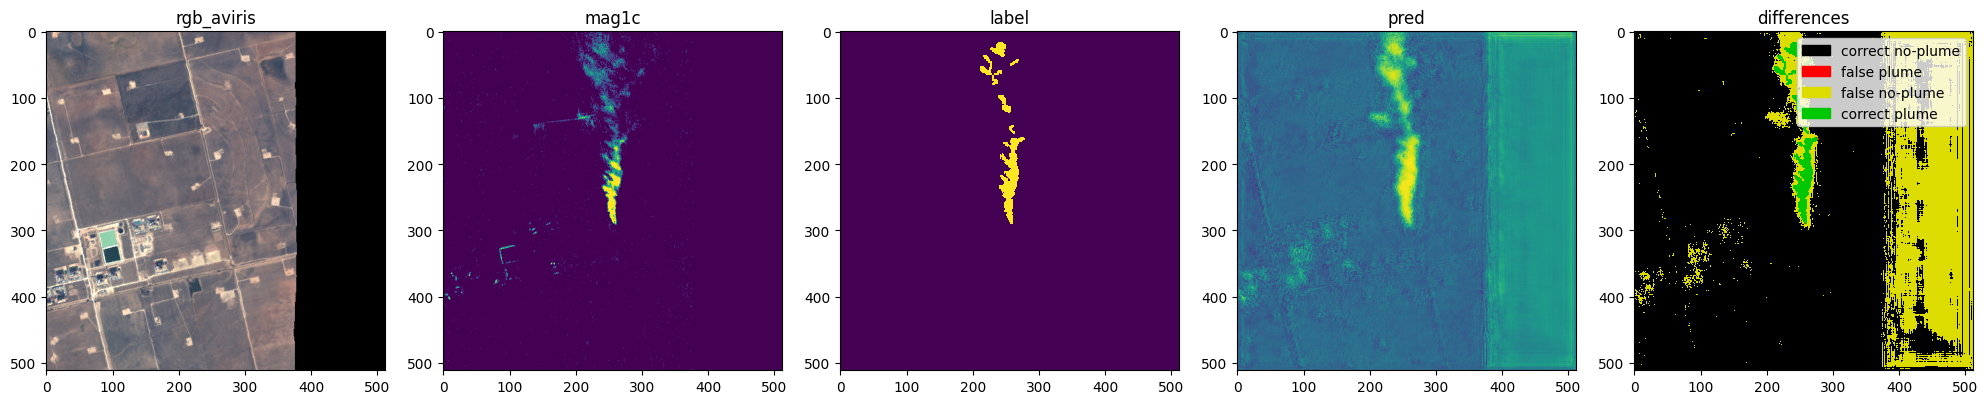

In [14]:
dataloader = hsi_dm.test_dataloader(batch_size=1)
how_many = 1
for i, plume_data in enumerate(dataloader):
    plume_data = hsi_model.batch_with_preds(to_device(plume_data, hsi_model.device))
    fig = starcoplot.plot_batch(to_device(plume_data,"cpu"), input_products=hsi_config.dataset.input_products,
                                products_plot=hsi_config.products_plot, figsize_ax=(4, 4))

    plt.show(fig)
    plt.close()

    how_many -=1
    if how_many <= 0: break

In [ ]:
# ^ The results of the model we just trained, note that with the "mini" dataset, these results aren't really all that good!